In [56]:
# %%capture
# !pip install torch numpy pandas matplotlib scikit-learn

# !pip install git+https://github.com/gretelai/gretel-synthetics.git

In [57]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as md
import os
import json
import torch
from pathlib import Path

from gretel_synthetics.timeseries_dgan.dgan import DGAN
from gretel_synthetics.timeseries_dgan.config import DGANConfig, OutputType



# Dataanalyse

In [58]:
# rootpath=os.getcwd()
# # go to the upper directory of rootpath
# rootpath=Path(rootpath).parents[0]
# #rootpath= './Thesis/Dataanalyse/'
# rootpath
# df=pd.read_csv(os.path.join(rootpath,'Dataanalyse/axis2_demo_tablepart1_0.csv'))
# with open (os.path.join(rootpath,'Dataanalyse/important_features.json'), 'r') as f:
#     features = json.load(f)[:10]
# features=['Timestamp']+features
# newdf=df[features]
# newdf=newdf.copy()
# newdf['Timestamp'] = pd.to_datetime(newdf['Timestamp'], unit='s')
# # create a new data column starting from the first timestamp, with a frequency of 1 second.
# newdf['datetime'] = pd.date_range(start=newdf['Timestamp'].iloc[0], periods=len(newdf), freq='S')
# newdf=newdf.drop(columns=['Timestamp'], axis=1)
# #change the last column to the first column
# cols = newdf.columns.tolist()   
# cols = cols[-1:] + cols[:-1]
# newdf=newdf[cols]
# newdf.head()
# newdf.to_csv('true_data.csv', index=False)

In [59]:
sensor_df=pd.read_csv('true_data.csv')
sensor_df.head()

COLUMNS = list(sensor_df.columns)
COLUMNS.remove('datetime')
# COLUMNS.remove('Variance_y')
# COLUMNS.remove('Variance_z')
# COLUMNS.remove('Variance_x')
train_df=sensor_df

In [60]:
train_df.columns

Index(['datetime', 'Standardabweichung_y', 'Variance_z', 'Variance_y',
       'Standardabweichung_z', 'Effektivwert_x',
       'Mittlere_Absolute_Abweichung_y', 'Effektivwert_y',
       'Standardabweichung_x', 'Mittelwert_x', 'Variance_x'],
      dtype='object')

In [61]:
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
# import pandas as pd
# # fig,axs = plt.subplots(10,1,figsize=(10,2*10))

# # for i,j in enumerate(COLUMNS) :

# #     axs[i].plot(train_df["datetime"],train_df[j],label='GroundTruth')

# #     axs[i].legend()
# #     plt.ylabel("Temperature (Celsius)")
# #     plt.xlabel("Date")
# #     plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1000))  # 每10天显示一次日期
# #     plt.xticks(rotation=90)
# # plt.show()
# # # 假设 train_df 已经正确载入，并且 "datetime" 列已经转换为 datetime 类型
# fig, axs = plt.subplots(10, 1, figsize=(10, 20))  # 高度根据特征数量动态调整

# for i,j in enumerate(COLUMNS) :
#     # 如果只有一列，当只有一个特征时，axs不是列表，需要做一下处理
#     ax = axs[i] 
    
#     ax.plot(train_df[j], label='Actual')
#     ax.legend()
# plt.ylabel("Temperature (Celsius)")
# plt.xlabel("Date")
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1000))  # 每10天显示一次日期
# plt.xticks(rotation=90)
# plt.tight_layout()  # 自动调整子图参数，使之填充整个图像区域
# plt.show()


In [62]:
# DGAN needs many example time series to train. Split into 1-day slices to
# create multiple examples.
features = train_df.drop(columns="datetime").to_numpy()
features =pd.DataFrame(features)
features.head()


,0,1,2,3,4,5,6,7,8,9
0,163.966,220962.0,26911.8,469.831,657.526,117.401,571.115,328.477,569.600,108005.0
1,171.940,235057.0,29592.9,484.584,627.592,122.691,571.746,309.810,545.792,96078.5
2,156.322,256573.0,24460.9,506.277,651.770,111.817,566.507,324.498,565.248,105404.0
3,174.714,241982.0,30555.6,491.670,653.578,123.620,568.931,325.453,566.784,106026.0
4,162.434,268509.0,26411.1,517.919,661.006,128.562,586.402,339.697,567.040,115510.0


In [98]:
features = train_df.drop(columns="datetime").to_numpy()
features.shape

(10000, 10)

In [85]:
n = features.shape[0] // 144
features = features[:(n*144),:]
features.shape

(9936, 10)

In [99]:
# Obsevations every 10 minutes, so 144 * 10 minutes = 1 day

n = features.shape[0] // 144
features = features[:(n*144),:].reshape(-1, 144, features.shape[1])
# Shape is now (# examples, # time points, # features)
features.shape

(69, 144, 10)

In [65]:
xaxis_1day = train_df["datetime"][0:144]
len(xaxis_1day)
int(len(xaxis_1day))/10

14.4

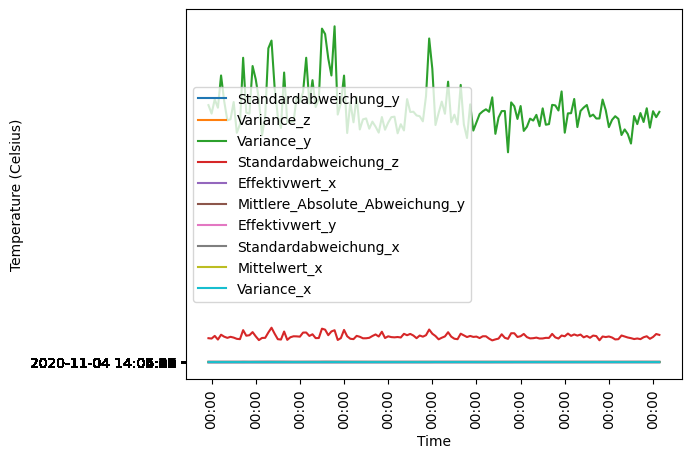

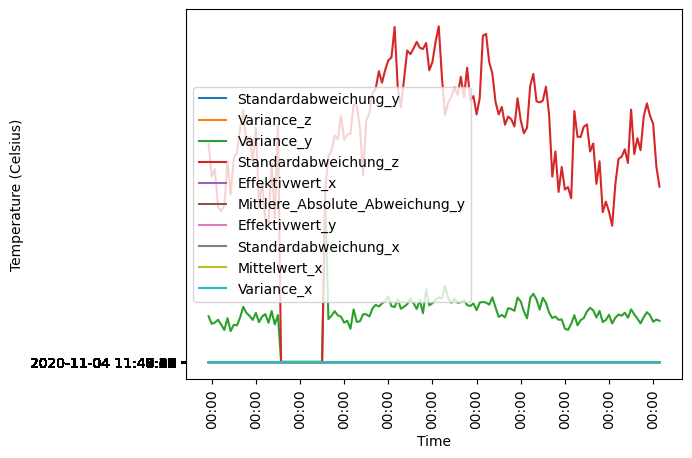

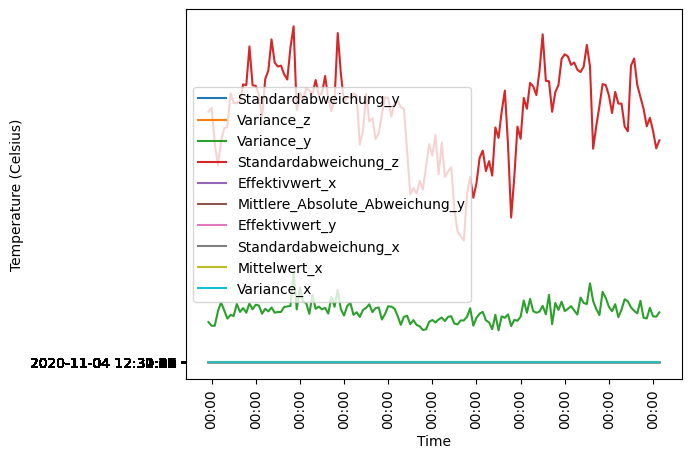

In [66]:
# Show a few of the 1-day training samples
xaxis_1day = train_df["datetime"][0:144]

def plot_day(f):
    for i, c in enumerate(COLUMNS):
        plt.plot(xaxis_1day, f[:,i], label=c)
    ax = plt.gca()
    ax.xaxis.set_major_locator(md.HourLocator(byhour=range(2,24,3)))
    ax.xaxis.set_major_formatter(md.DateFormatter("%H:%M"))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=int(len(xaxis_1day)/10)))  # 每10天显示一次日期

    plt.legend()
    plt.xlabel("Time")
    plt.xticks(rotation=90)

    plt.ylabel("Temperature (Celsius)")
    plt.show()

plot_day(features[60,:,:])
plot_day(features[3,:,:])
plot_day(features[21,:,:])

In [67]:
# Recommended to train with a GPU
torch.cuda.is_available()

True

In [68]:
features.shape

(69, 144, 11)

In [69]:
max_sequence_len=features.shape[1]
max_sequence_len

144

In [70]:
features.shape

(69, 144, 11)

In [71]:
features[:,:,9].shape

(69, 144)

In [72]:
%%capture

# Train DGAN model
model = DGAN(DGANConfig(
    max_sequence_len=features.shape[1],
    sample_len=24,
    batch_size=min(1000, features.shape[0]),
    apply_feature_scaling=True,
    apply_example_scaling=False,
    use_attribute_discriminator=False,
    generator_learning_rate=1e-4,
    discriminator_learning_rate=1e-4,
    epochs=500,
))

model.train_numpy(
    features,
    feature_types=[OutputType.CONTINUOUS] * features.shape[2],
)

# Generate synthetic data
_,synthetic_features = model.generate_numpy(1000)



ValueError: could not convert string to float: '2020-11-04 11:40:00'

In [73]:
synthetic_features=np.array(synthetic_features)
synthetic_features.shape

(1000, 144, 10)

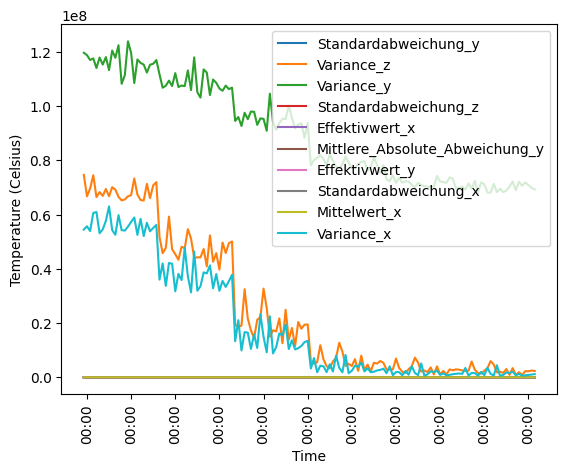

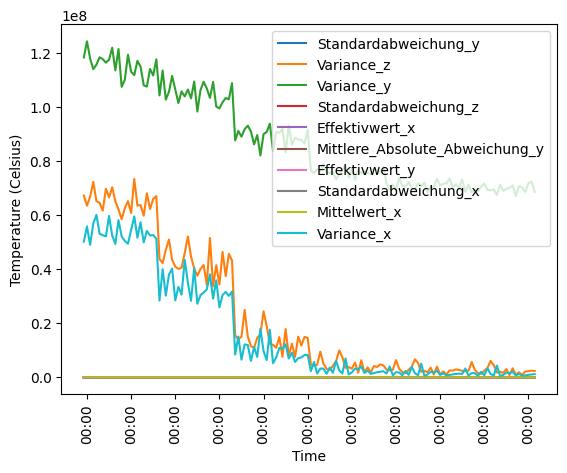

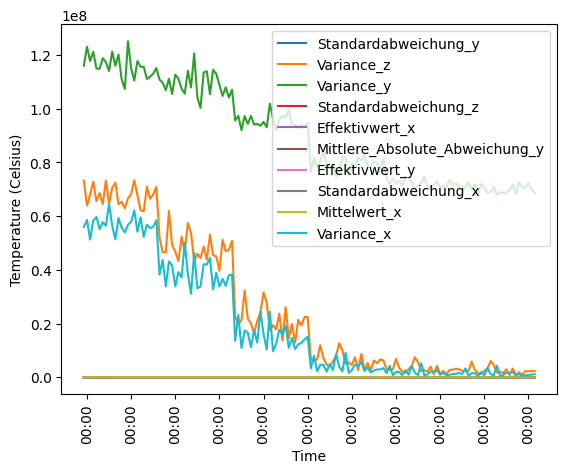

In [74]:
# Show some synthetic 1-day samples
plot_day(synthetic_features[825,:,:])
plot_day(synthetic_features[42,:,:])
plot_day(synthetic_features[496,:,:])

# Overall trends are similar to training samples, but with more local noise

In [75]:
# Compare (non-temporal) correlations between the 4 temperatures
synthetic_df = pd.DataFrame(synthetic_features.reshape(-1, synthetic_features.shape[2]), columns=train_df.columns[1:])

print("Correlation in real data:")
print(train_df.corr())
print()
print("Correlation in synthetic data:")
print(synthetic_df.corr())

# Correlations between temperature variables are similar

Correlation in real data:
                                Standardabweichung_y  Variance_z  Variance_y  \
Standardabweichung_y                        1.000000    0.941946    0.988749   
Variance_z                                  0.941946    1.000000    0.939674   
Variance_y                                  0.988749    0.939674    1.000000   
Standardabweichung_z                        0.985947    0.978185    0.968252   
Effektivwert_x                              0.883991    0.885047    0.873322   
Mittlere_Absolute_Abweichung_y              0.998660    0.937596    0.993809   
Effektivwert_y                              0.999932    0.942071    0.989190   
Standardabweichung_x                        0.886929    0.887463    0.875929   
Mittelwert_x                                0.652976    0.613081    0.637845   
Variance_x                                  0.671064    0.727340    0.679994   

                                Standardabweichung_z  Effektivwert_x  \
Standardabweichung_y 

C:\Users\28968\AppData\Local\Temp\ipykernel_21928\2394217800.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(train_df.corr())


In [76]:
# 为简单起见，我们可以聚焦于比较单个特征
real_data_feature = features[:, :, 0]  # 选择第一个特征
synthetic_data_feature = synthetic_features[:, :, 0]

In [77]:
real_data_feature.shape

(69, 144)

ValueError: could not convert string to float: '2020-11-04 11:40:00'

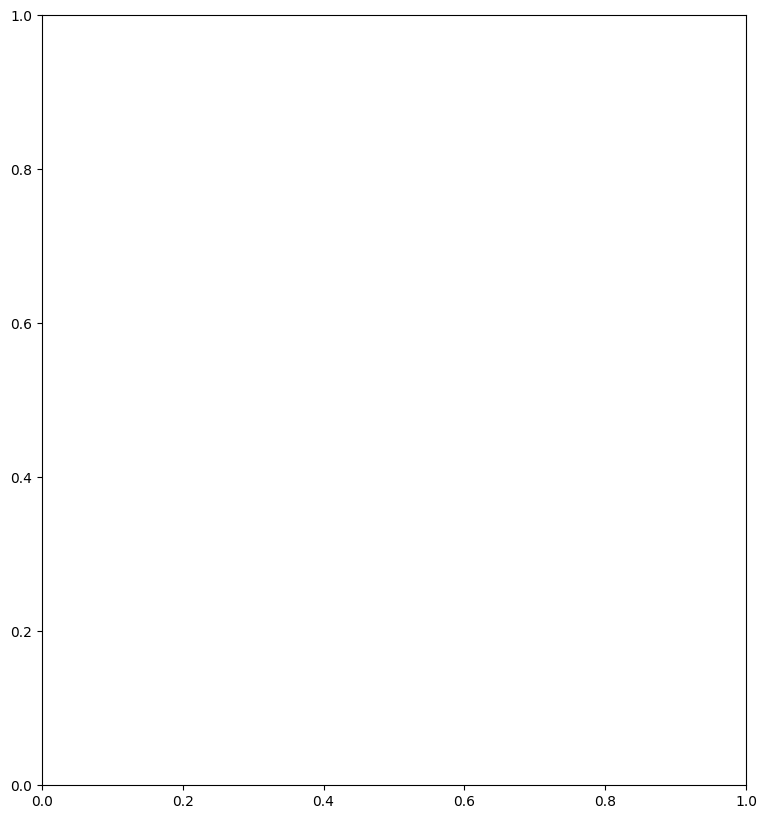

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.heatmap(real_data_feature, annot=False, cmap='coolwarm', cbar=True)
plt.title('Real Data Heatmap')
plt.xlabel('Feature Index')
plt.ylabel('Sample Index')

plt.subplot(1, 2, 2)
sns.heatmap(synthetic_data_feature, annot=False, cmap='coolwarm', cbar=True)
plt.title('Synthetic Data Heatmap')
plt.xlabel('Feature Index')
plt.ylabel('Sample Index')

plt.show()


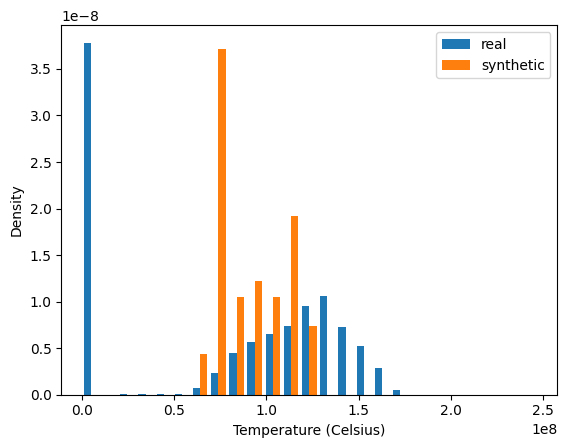

In [ ]:
# Compare distribution of T_out values
plt.hist([features[:,:,2].flatten(), synthetic_features[:,:,2].flatten()], 
         label=["real", "synthetic"],
         bins=25,
         density=True)
plt.legend()
plt.xlabel("Temperature (Celsius)")
plt.ylabel("Density")
plt.show()

# Temperature distribution for T_out is similar

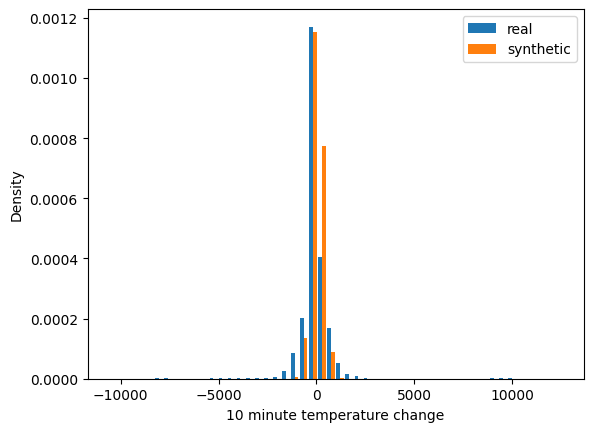

In [ ]:
# Compare distribution of 1-step (10 minute) diffs for T_out
real_diffs = np.diff(features, axis=1)
synthetic_diffs = np.diff(synthetic_features, axis=1)

plt.hist([real_diffs[:,:,0].flatten(), synthetic_diffs[:,:,0].flatten()],
         label=["real", "synthetic"],
         bins=50,
         density=True)
plt.legend()
plt.xlabel("10 minute temperature change")
plt.ylabel("Density")
plt.show()

# 1-step diffs for synthetic data have higher variance, this aligns with the
# increased noise visible in the plots